# Titanic: Machine Learning from Disaster
---

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_validate
from sklearn.metrics import f1_score, accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [2]:
# Load the dataset
data = pd.read_csv("./data/train.csv")

## Exploring the data

In [3]:
display(data.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_size = data.shape[0]
percent_positive = data[data['Survived'] == 1].shape[0] / train_size
percent_negative = data[data['Survived'] == 0].shape[0] / train_size

In [5]:
print("Number of training examples: {}".format(train_size))
print("Positive examples: {:2.0f}%".format(percent_positive*100))
print("Negative examples: {:2.0f}%".format(percent_negative*100))

Number of training examples: 891
Positive examples: 38%
Negative examples: 62%


**Note**: The data is skewed towards negative samples, so accuracy might be misleading as a metric. We'll use the F1 score instead.

---
## Dealing with NaNs

In [6]:
display(data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

* `Age`: it makes sense to use the mean as a replacement for missing values, to represent the "expected" age of the passengers.
* `Cabin`: in this dataset, missing cabin values indicate that a passenger was not in a cabin. This could be useful information, so we'll turn missing values into their own feature called "U" for "Unknown".
* `Embarked`: similar to cabin numbers, we're simply going to assume that the port passengers were picked up from was random. This isn't necessarily true, since richer passengers (for example) might have picked up more frequently from one port rather than another.

In [7]:
# Replace all Age NaNs with the mean age
data["Age"].fillna(np.around(data["Age"].mean(), decimals=1), inplace=True)

In [8]:
# Replace missing values with "Unknown"
data["Cabin"].fillna("Unknown", inplace=True)

In [9]:
# Forward/back fill Embarked NaNs
data["Embarked"].fillna(method="ffill", inplace=True)
data["Embarked"].fillna(method="backfill", inplace=True)

In [10]:
# Confirm NaNs are gone
print("Age NaN count: {}".format(data["Age"].isnull().sum()))
print("Cabin NaN count: {}".format(data["Cabin"].isnull().sum()))
print("Embarked NaN count: {}".format(data["Embarked"].isnull().sum()))

Age NaN count: 0
Cabin NaN count: 0
Embarked NaN count: 0


---
## One-hot encoding

The categorical features `Pclass`, `Sex`, `Cabin`, and `Embarked` need one-hot encoding to be useful.

If we one-hot encoded `Cabin` as-is, we would have too many features as a result, since we would be including every single cabin passengers were in. Instead, we can discard the cabin number and only focus on the deck they were on, denoted by the letter. E.g. cabin C123 is cabin 123 on deck C. This should give us the relevant information about the passengers' location on the ship, without filling the dataset with a ton of unimportant features.

In [11]:
# Prepare Cabin for one-hot encoding
data["Cabin"] = data["Cabin"].apply(lambda s: s[0])

In [12]:
# Check cabin column
display(data["Cabin"].head(10))

0    U
1    C
2    U
3    C
4    U
5    U
6    E
7    U
8    U
9    U
Name: Cabin, dtype: object

In [13]:
# Perform one-hot encoding
data = pd.get_dummies(data, columns=["Pclass", "Sex", "Cabin", "Embarked"])

In [14]:
# Check one-hot encoded features
print(data.columns)

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Cabin_U', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')


Now we can compute the correlation of the cabins labeled "Unknown" with the target to see if it's indeed a useful feature.

In [15]:
print("Correlation between 'Cabin_U' and 'Survived': {}".format(data.corr()["Survived"]["Cabin_U"]))

Correlation between 'Cabin_U' and 'Survived': -0.3169115231122935


Indeed, the correlation is high enough for `Cabin_U` to be considered a useful feature. This justifies our earlier decision to keep those missing values as part of the dataset.

---
## Removing unimportant features

We are going to assume that the names of the passengers, as well as their ID and ticket number, are irrelevant to their chance of survival (i.e. they're random) and we'll remove them from the dataset.

Additionally, as we can see below that `Embarked_Q` has a very low correlation with the target (less than 0.01). So, we're going to remove that feature as well.

In [16]:
display(data.corr()["Survived"])

PassengerId   -0.005007
Survived       1.000000
Age           -0.069811
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Pclass_1       0.285904
Pclass_2       0.093349
Pclass_3      -0.322308
Sex_female     0.543351
Sex_male      -0.543351
Cabin_A        0.022287
Cabin_B        0.175095
Cabin_C        0.114652
Cabin_D        0.150716
Cabin_E        0.145321
Cabin_F        0.057935
Cabin_G        0.016040
Cabin_T       -0.026456
Cabin_U       -0.316912
Embarked_C     0.171485
Embarked_Q     0.008660
Embarked_S    -0.155660
Name: Survived, dtype: float64

In [17]:
# Drop uninteresting features
data = data.drop(columns=["Name", "Ticket", "PassengerId", "Embarked_Q"])
display(data.head())

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,...,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_S
0,0,22.0,1,0,7.2500,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,1
3,1,35.0,1,0,53.1000,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
4,0,35.0,0,0,8.0500,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,1


## Removing highly-correlated features

From the heatmap below, we can spot which features are highly correlated with each other. In this case, we notice that the 3 `Pclass` features (particularly classes 1 and 3) are highly correlated with the fare. This makes sense, since `Pclass` represents the ticket class the passengers bought, which gets more expensive the higher it is. Since `Fare` can be predicted using `Pclass`, we're going to remove `Fare` from the dataset, to eliminate duplicate information.

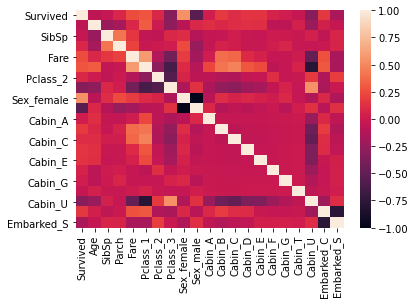

In [18]:
# Draw heatmap from the correlation table 
sns.heatmap(data.corr())
plt.show()

In [19]:
# Display a table with the correlations between the 3 classes and the fare
corr = data.corr()
df = pd.DataFrame(data=[
                        [corr["Pclass_1"]["Fare"], 
                         corr["Pclass_2"]["Fare"], 
                         corr["Pclass_3"]["Fare"]]], 
                  columns=["Pclass_1", "Pclass_2", "Pclass_3"], 
                  index=["Fare"])
display(df)

,Pclass_1,Pclass_2,Pclass_3
Fare,0.591711,-0.118557,-0.413333


In [20]:
# Drop the Fare from the dataset
data = data.drop(columns=["Fare"])

---

## Feature Scaling

The only continuous feature left in the dataset is `Age`. We are going to normalise it so that it's values are between 0 and 1.

In [21]:
# Normalise the age feature
data["Age"] = (data["Age"] - data["Age"].mean()) / (data["Age"].max() - data["Age"].min())

---

## Model selection

Normally, we would do a train/test split and leave the test set aside for the final model evaluation. However, we can use Kaggle's test set for that, so we don't have to sacrifice any training data. Now, let's split the data into features and labels.

In [23]:
# Split data into X_train and y_train
X_train = data.iloc[:, 1:]
y_train = data["Survived"]

### Train-Predict Pipeline

The following function will serve as a train-predict pipeline.

In [28]:
def train_predict(model, score="f1"):
    """
    Computes the cross-validation score of a given model using a given metric.
    
    :model: model to evaluate
    :score: scoring metric to use for cross-validation
    :return: tuple with training and validation scores
    """
    
    # Create scorer object
    if score == "accuracy":
        scorer = make_scorer(accuracy_score)
    elif score == "f1":
        scorer = make_scorer(f1_score)
    
    # 5-fold cross-valdation
    cv_results = cross_validate(model, X_train, y_train, scoring=scorer, cv=5, return_train_score=True)
    train_score = cv_results["train_score"]
    val_score = cv_results["test_score"]
    
    return train_score, val_score

### Model Evaluation
Now let's use the train-predict pipeline to get the CV scores for each of our models.

In [29]:
# Compute the score of every model
models = [LogisticRegression(random_state=42), SVC(random_state=42), AdaBoostClassifier(random_state=42)]
scores = [train_predict(model) for model in models]

In [31]:
# Display a table with the scores
df_scores = pd.DataFrame(data=[[np.mean(score[0]) for score in scores], [np.mean(score[1]) for score in scores]], index=["Train", "Validation"], columns=[type(model).__name__ for model in models])
display(df_scores)

,LogisticRegression,SVC,AdaBoostClassifier
Train,0.756956,0.758537,0.784690
Validation,0.726312,0.714940,0.757537


From the table above we can see that AdaBoost has the highest cross-validation scores, so we'll choose that as our model.

In [34]:
chosen_model = AdaBoostClassifier(random_state=42)

Let's plot a learning curve for our model to assess whether it's overfitting or underfitting.

In [37]:
def plot_learning_curve(model):
    
    start = time.time()
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, scoring=make_scorer(f1_score), random_state=42)
    end = time.time()
    print("Learning curve time: {:0.2f}s".format(end-start))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean, train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean, test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")

    plt.show()

Learning curve time: 2.21s


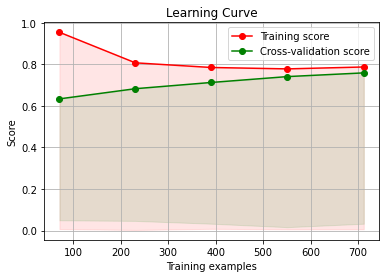

In [38]:
plot_learning_curve(chosen_model)

From the learning curve we can see that the training and validation scores converge just below 0.8. This indicates the default model is underfitting the data a bit. Let's perform hyperparameter tuning to see if we can improve the performance.

---
## Hyperparameter Tuning

In [39]:
parameters = {"n_estimators": [50, 100, 200, 500, 1000], "learning_rate": [0.001, 0.05, 0.1, 0.5, 1.0]}

In [40]:
grid_search = GridSearchCV(chosen_model, param_grid=parameters, scoring=make_scorer(f1_score))

run = False
if run:
    start = time.time()
    grid_fit = grid_search.fit(X_train, y_train)
    end = time.time()
    print("Grid search time: {:2.2f}s".format(end-start))

Grid search time: 64.33s


In [63]:
# Print the best model
best_clf = grid_fit.best_estimator_
print(best_clf)

AdaBoostClassifier(learning_rate=0.5, random_state=42)


In [65]:
print(best_clf.n_estimators)

50


In [42]:
# Save tuned model to file
from joblib import dump, load
dump(best_clf, "./tuned_model.joblib")

['./tuned_model.joblib']

---
## Final Model Evaluation

After the initial evaluation the model seemed to be underfitting the data. So, now we'll manually change the parameters of the model to increase accuracy. Specifically, we'll increase the number of estimators to 1000 and decrease the learning rate to 0.01

In [75]:
best_clf.n_estimators = 1000
best_clf.learning_rate = 0.01

In [89]:
# Save the model
from joblib import dump, load
dump(best_clf, "./tuned_model.joblib")

['./tuned_model.joblib']

Learning curve time: 36.21s


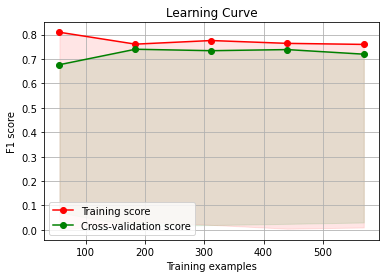

In [77]:
# Learning curve
plot_learning_curve(best_clf)

In [78]:
f1_train, f1_test = train_predict(best_clf)
print("F1 score (train): {:0.2f}".format(f1_train))
print("F1 score (test): {:0.2f}".format(f1_test))

F1 score (train): 0.76
F1 score (test): 0.76


---

## Final Training and Submission

In [79]:
# Load the test set
test = pd.read_csv("./data/test.csv")

In [80]:
# Remove missing values
test["Age"].fillna(np.around(test["Age"].mean(), decimals=1), inplace=True)
test["Cabin"].fillna("Unknown", inplace=True)
test["Embarked"].fillna(method="ffill", inplace=True)
test["Embarked"].fillna(method="backfill", inplace=True)

# One-hot encoding
test["Cabin"] = test["Cabin"].apply(lambda s: s[0])
test = pd.get_dummies(test, columns=["Pclass", "Sex", "Cabin", "Embarked"])

# Drop unimportant features
test = test.drop(columns=["Name", "Ticket", "PassengerId", "Embarked_Q"])
test = test.drop(columns=["Fare"])

# Feature scaling
test["Age"] = (test["Age"] - test["Age"].mean()) / (test["Age"].max() - test["Age"].min())

In [81]:
display(test.head())

,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U,Embarked_C,Embarked_S
0,0.055674,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
1,0.220517,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1
2,0.418327,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
3,-0.043231,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1
4,-0.109168,1,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1


In [82]:
# Add missing column to test set
test["Cabin_T"] = np.zeros(test.shape[0])

In [83]:
# Display test to confirm
display(test.head())

,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U,Embarked_C,Embarked_S,Cabin_T
0,0.055674,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0.0
1,0.220517,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0.0
2,0.418327,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0.0
3,-0.043231,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0.0
4,-0.109168,1,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0.0


In [84]:
# Use the whole dataset for training
X = data.iloc[:, 1:]
y = data["Survived"]
best_clf = best_clf.fit(X, y)

In [85]:
# Predict test labels
test_labels = pd.Series(best_clf.predict(test))

In [86]:
# Load passenger labels
test_orig = pd.read_csv("./data/test.csv")
ids = test_orig["PassengerId"]

In [87]:
# Create DataFrame for submission
test_submission = pd.DataFrame(data={"PassengerId": ids, "Survived": test_labels})
display(test_submission)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [88]:
# Produce submission file
test_submission.to_csv("./data/submission.csv", index=False)